# **Tutorial File for RRMPG - Alpine**

In this notebook, we will explore new implementations of the **RRMPG-Alpine** package, focusing on hydrological modeling and climate data analysis for the **Fagge (Gepatschalm) catchment**. 

The provided dataset, **fag_gep_modified.csv**, includes daily measurements from the catchment area. These data points cover a range of hydrological and climatic variables:

| **Variable**              | **Source**                                                                                                                                                    |
|---------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Precipitation [mm]**     | [1] Hiebl, J.; Frei, C. (2018): *Daily precipitation grids for Austria since 1961—development and evaluation of a spatial dataset for hydroclimatic monitoring and modelling*. Theor Appl Climatol 132 (1-2), 327–345. DOI: [10.1007/s00704-017-2093-x](https://doi.org/10.1007/s00704-017-2093-x) |
| **Tmax [°C]**              | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **Tmin [°C]**              | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **Tmean [°C]**             | [2] Hiebl, J.; Frei, C. (2016): *Daily temperature grids for Austria since 1961—concept, creation and applicability*. Theor Appl Climatol 124 (1-2), 161–178. DOI: [10.1007/s00704-015-1411-4](https://doi.org/10.1007/s00704-015-1411-4) |
| **ET0 [mm]**               | [3] Haslinger, K.; Bartsch, A. (2016): *Creating long-term gridded fields of reference evapotranspiration in Alpine terrain based on a recalibrated Hargreaves method*. Hydrology and Earth System Sciences 20(3), 1211-1223. DOI: [10.5194/hess-20-1211-2016](https://doi.org/10.5194/hess-20-1211-2016) |
| **Qmm [mm]**               | [4] eHYD – *Austrian Hydrological Data Service*: [eHYD](https://ehyd.gv.at/#)                                                                                  |
| **Snow Cover Data** for 5 elevation bands      | [5] MODIS – *MODIS Snow Cover Data*: [NSIDC MODIS](https://nsidc.org/data/modis)                                                                              |

---

## **Modeling Tasks to Be Performed:**

The following tasks will be performed using the provided data:

1. **Cemaneige + Hysteresis + Icemelt + GR4J**
2. **Cemaneige + Hysteresis + GR4J**
3. **Cemaneige + Icemelt + GR4J**
4. **Calculate ET0 using PyET**
5. **Calibration using SCE-UA Algorithm**
6. **Visualization and Analysis**



## **Input**

In [ ]:
# Notebook setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import spotpy

from rrmpg.models import CemaneigeHystGR4J, CemaneigeGR4JIce, CemaneigeHystGR4JIce
from spotpy.objectivefunctions import kge
from spotpy.parameter import Uniform
from scipy.stats import gamma
import pyet

In [3]:
# fag_gep
df_in = pd.read_csv("fag_gep_modified.csv", index_col="Date", sep=";", decimal=".", parse_dates=["Date"])
df_in.index

DatetimeIndex(['2000-02-26', '2000-02-27', '2000-02-28', '2000-02-29',
               '2000-03-01', '2000-03-02', '2000-03-03', '2000-03-04',
               '2000-03-05', '2000-03-06',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=7959, freq=None)

In [ ]:
# define the elevations
elevation = [float(2277.84423828125), # Mean elevation band 1
            float(2641.563720703125), # Mean elevation band 2
            float(2845.09521484375), # Mean elevation band 3
            float(3002.329833984375), # Mean elevation band 4
            float(3227.36669921875)] # Mean elevation band 5

mean_elev = 2798.84033203125 # Mean elevation of the catchment

In [5]:
# Glacier fraction for each elevation layer
frac_ice = np.array([0.022034026, 0.042062109, 0.246620231, 0.507329678, 0.709368134])

In [ ]:
# Generating a dataframe to store the simulated discharges
# Initialize columns with no data
df1 = pd.DataFrame({
    'Datum': df_in.index,  # Using the index of df_in for the 'Datum' column
    'Qmm': df_in['Qmm'],  # Column 'Qmm' from df_in
    'sim HystIce(mm/d)': np.nan, # Cemaneige + Hysteresis + Icemelt + GR4J
    'sim Hyst(mm/d)': np.nan, # Cemaneige + Hysteresis + GR4J
    'sim CemaneigeIce(mm/d)': np.nan, # Cemaneige + Icemelt + GR4J
    'Q_sceua(mm/d)': np.nan}) # SCE-UA with PyET ET0

# Display the first few rows of df1
print(df1.head())

                Datum       Qmm  sim HystIce(mm/d)  sim Hyst(mm/d)  \
Date                                                                 
2000-02-26 2000-02-26  0.263825                NaN             NaN   
2000-02-27 2000-02-27  0.260942                NaN             NaN   
2000-02-28 2000-02-28  0.258058                NaN             NaN   
2000-02-29 2000-02-29  0.258058                NaN             NaN   
2000-03-01 2000-03-01  0.258058                NaN             NaN   

            sim CemaneigeIce(mm/d)  Q_sceua (mm/d)  
Date                                                
2000-02-26                     NaN             NaN  
2000-02-27                     NaN             NaN  
2000-02-28                     NaN             NaN  
2000-02-29                     NaN             NaN  
2000-03-01                     NaN             NaN  


## **Cemaneige + Hysteresis + Icemelt + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** + **Hysteresis** + **Icemelt Model** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using an **objective function** :

- **75% Discharge Data** (Qmm): Used to calibrate the model's hydrological performance.
- **25% Remote Sensing Snow Cover Data**: This is split across the 5 elevation bands, with 5% allocated per elevation band for snow cover calibration.

### **Loss Metric Options**

During the calibration process, users can select between two different loss metrics to evaluate model performance:

1. **Kling-Gupta Efficiency (KGE)**
   
2. **Mean Squared Error (MSE)**


In [7]:
# Define the model with initial parameters
model1 = CemaneigeHystGR4JIce()
params1= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'Thacc': 43, 'Rsp': 0.23, # Hysteresis parameters
          'x1': 210, 'x2': 3.4, # GR4J parameters
          'x3': 49, 'x4': 2.2, # GR4J parameters
          "DDF": 5} # Icemelt parameters
model1.set_params(params1) # Set the parameters

In [8]:
# NDSI from df_in into SCA (snow covered area) for each band
sca1modis = (0.06 + 1.21 * df_in["NDSI1"]).clip(upper=100)
sca2modis = (0.06 + 1.21 * df_in["NDSI2"]).clip(upper=100)
sca3modis = (0.06 + 1.21 * df_in["NDSI3"]).clip(upper=100)
sca4modis = (0.06 + 1.21 * df_in["NDSI4"]).clip(upper=100)
sca5modis = (0.06 + 1.21 * df_in["NDSI5"]).clip(upper=100)

In [9]:
# Fit the model
# Choose the loss metric: kge or mse
result = model1.fit_Q_SCA(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], frac_ice, sca1modis, sca2modis, sca3modis, sca4modis, sca5modis,
                    met_station_height=mean_elev, loss_metric="kge", # mse or kge 
                    altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.18688101205827204
                   x: [ 9.030e-01  2.223e+00  8.287e+01  1.000e+00
                        3.730e+01  3.000e+00  2.328e+01  1.282e+00
                        6.287e+00]
                 nit: 59
                nfev: 8910
          population: [[ 9.030e-01  2.242e+00 ...  1.293e+00  5.274e+00]
                       [ 9.078e-01  2.186e+00 ...  1.287e+00  7.778e+00]
                       ...
                       [ 8.727e-01  2.164e+00 ...  1.276e+00  6.500e+00]
                       [ 8.581e-01  2.158e+00 ...  1.235e+00  8.011e+00]]
 population_energies: [ 1.869e-01  1.906e-01 ...  1.895e-01  1.904e-01]
                 jac: [ 0.000e+00 -5.401e-05  1.677e-05 -9.214e-03
                        4.304e-05 -7.466e-03  6.274e-05 -3.086e-05
                       -3.378e-05]


In [10]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model1.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model1.set_params(params)

# To be sure, let's look at the current model parameters
model1.get_params()

{'CTG': np.float64(0.9030015353603938),
 'Kf': np.float64(2.223066466942482),
 'Thacc': np.float64(82.87006309545102),
 'Rsp': np.float64(1.0),
 'x1': np.float64(37.298698767874896),
 'x2': np.float64(3.0),
 'x3': np.float64(23.276144152901534),
 'x4': np.float64(1.282197809132866),
 'DDF': np.float64(6.286671950232253)}

In [11]:
# Simulate the discharge and sca, icemlet, snowmelt, rain
# Store the simulated discharge in the df1 dataframe
df1['sim HystIce(mm/d)'],_,_,_,_,sca, icemelt, snowmelt, rain = model1.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2, return_storages=True) # Return the storages sca, icemelt, snowmelt, rain

## **Cemaneige + Hysteresis + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** with **Hysteresis** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using an **objective function** :

- **75% Discharge Data** (Qmm): Used to calibrate the model's hydrological performance.
- **25% Remote Sensing Snow Cover Data**: This is split across the 5 elevation bands, with 5% allocated per elevation band for snow cover calibration.

### **Loss Metric Options**

During the calibration process, users can select between two different loss metrics to evaluate model performance:

1. **Kling-Gupta Efficiency (KGE)**
   
2. **Mean Squared Error (MSE)**

In [12]:
# Define the model with initial parameters
model2 = CemaneigeHystGR4J()
params2= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'Thacc': 43, 'Rsp': 0.23,  # Hysteresis parameters
          'x1': 210, 'x2': 3.4,
          'x3': 49, 'x4': 2.2}  # GR4J parameters
model2.set_params(params2)

In [13]:
# NDSI from df_in into SCA
sca1modis = (0.06 + 1.21 * df_in["NDSI1"]).clip(upper=100)
sca2modis = (0.06 + 1.21 * df_in["NDSI2"]).clip(upper=100)
sca3modis = (0.06 + 1.21 * df_in["NDSI3"]).clip(upper=100)
sca4modis = (0.06 + 1.21 * df_in["NDSI4"]).clip(upper=100)
sca5modis = (0.06 + 1.21 * df_in["NDSI5"]).clip(upper=100)

In [14]:
result = model2.fit_Q_SCA(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], sca1modis, sca2modis, sca3modis, sca4modis, sca5modis, met_station_height=mean_elev, loss_metric="kge", # mse or kge 
                    altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.19273413442184115
                   x: [ 9.370e-01  2.352e+00  8.318e+01  1.000e+00
                        1.000e+01  3.000e+00  2.118e+01  1.286e+00]
                 nit: 68
                nfev: 8505
          population: [[ 9.370e-01  2.385e+00 ...  2.070e+01  1.282e+00]
                       [ 9.215e-01  2.322e+00 ...  2.091e+01  1.275e+00]
                       ...
                       [ 9.423e-01  2.392e+00 ...  2.051e+01  1.293e+00]
                       [ 9.381e-01  2.354e+00 ...  2.050e+01  1.293e+00]]
 population_energies: [ 1.927e-01  1.943e-01 ...  1.941e-01  1.939e-01]
                 jac: [ 0.000e+00 -8.071e-06 -5.884e-07 -1.925e-02
                        6.980e-05 -1.477e-02  1.890e-06 -2.032e-06]


In [15]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model2.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model2.set_params(params)

# To be sure, let's look at the current model parameters
model2.get_params()

{'CTG': np.float64(0.9370422854981424),
 'Kf': np.float64(2.352286935680163),
 'Thacc': np.float64(83.18303250166798),
 'Rsp': np.float64(1.0),
 'x1': np.float64(10.0),
 'x2': np.float64(3.0),
 'x3': np.float64(21.18412983923393),
 'x4': np.float64(1.2863423622675372)}

In [16]:
# Simulate the discharge and store it in the df1 dataframe
df1['sim Hyst(mm/d)']= model2.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

## **Cemaneig + Icemelt + GR4J**

This section describes the setup and calibration process for the coupled hydrological model, which integrates the following components:

- **Cemaneige Snow Model** (**WITHOUT** Hysteresis) + **Icemelt Model** + **GR4J Rainfall-Runoff Model**

### **Calibration Methodology**

The calibration of the coupled model is performed using a **loss-function** only on discharge data. The available loss metric is **Mean Squared Error (MSE)**.

In [17]:
# Define the model with initial parameters
model3 = CemaneigeGR4JIce()
params3= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'x1': 210, 'x2': 3.4,
          'x3': 49, 'x4': 2.2, # GR4J parameters
          "DDF": 5}   # Icemelt parameters
model3.set_params(params3)

In [18]:
# Fit the model
result = model3.fit(df_in["Qmm"], df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                    df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev,
                    altitudes=elevation, s_init=0.5, r_init=0.4)
print(result)

             message: Optimization terminated successfully.
             success: True
                 fun: 6.9031288676820255
                   x: [ 7.382e-01  4.075e+00  2.124e+02  2.971e+00
                        2.796e+01  1.261e+00  3.915e+00]
                 nit: 32
                nfev: 4353
          population: [[ 7.382e-01  4.075e+00 ...  1.261e+00  3.915e+00]
                       [ 6.984e-01  4.039e+00 ...  1.364e+00  5.059e+00]
                       ...
                       [ 7.088e-01  4.135e+00 ...  1.317e+00  4.001e+00]
                       [ 7.612e-01  4.153e+00 ...  1.319e+00  3.653e+00]]
 population_energies: [ 6.903e+00  7.146e+00 ...  6.937e+00  6.947e+00]


In [19]:
# Set the model parameters to the ones found by the calibration
params = {}

param_names = model3.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model3.set_params(params)

# To be sure, let's look at the current model parameters
model3.get_params()

{'CTG': np.float64(0.7382413930079459),
 'Kf': np.float64(4.075326104566461),
 'x1': np.float64(212.43962540529526),
 'x2': np.float64(2.9706486961437353),
 'x3': np.float64(27.958582971315394),
 'x4': np.float64(1.2609133662872083),
 'DDF': np.float64(3.9153425908335393)}

In [20]:
df1['sim CemaneigeIce(mm/d)']= model3.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                            df_in['Tmax'], df_in['ET0'], frac_ice, met_station_height=mean_elev, 
                            altitudes=elevation, s_init=0.5, r_init=0.4)

## **ET0 Calculation with PyET**

In alpine regions **ET0** data is sometimes unavailable, the **PyET** package can be used to calculate **ET0**. PyET is a Python library that provides methods to estimate reference evapotranspiration using various approaches, including the **Hargreaves** method, which is commonly used in regions with limited meteorological data.


In [ ]:
# Load the dataframe without the ET0 column
df_in = pd.read_csv("fag_gep_modified.csv", index_col="Date",  sep=";", decimal=".").drop(columns="ET0")

# Use Hargreaves or Oudin method from PyET to calculate ET0
lat = 46.9685*np.pi/180 # latitude of site
df_in["ET0"] = pyet.hargreaves(df_in["Tmean"], df_in["Tmax"], df_in["Tmin"], lat=lat) # Hargreaves
#df_in["ET0"] = pyet.oudin(df_in["Tmean"], lat=lat) # Oudin

## **Model Calibration with Spotpy**

This section outlines the integration of the **SCE-UA algorithm** (Shuffled Complex Evolution – University of Arizona) from the **Spotpy** package for model calibration.
The **SCE-UA algorithm** is employed to optimize the model parameters by minimizing the already introduced objective function. The calibration process is carried out for the following model combination:
- **Cemaneige Snow Model** with **Hysteresis** + **GR4J Rainfall-Runoff Model**

The **objective function** evaluates the model's performance using the **KGE** during the calibration process. The SCE-UA algorithm uses this function to guide the optimization process, ensuring the model parameters are calibrated to achieve the best possible fit to the observed data.

In [22]:
# Define the model with initial parameters
model4 = CemaneigeHystGR4J()
params4= {'CTG': 0.43, 'Kf': 3.5, # Cemaneige parameters
          'Thacc': 43, 'Rsp': 0.23,  # Hysteresis parameters
          'x1': 210, 'x2': 3.4,
          'x3': 49, 'x4': 2.2}   # GR4J parameters
model4.set_params(params4)

In [23]:
# Setup of the spotpy class
class spot_setup_gr4jhyst(object):  
    ctg = Uniform("CTG", low=0.1, high=1, optguess=0.8)
    kf = Uniform("Kf", low=0.1, high=10, optguess=4)  
    thacc = Uniform("thacc",  low=1, high=1000, optguess=400)
    rsp = Uniform("Rsp",  low=0.1, high=1, optguess=0.8) 
    x1 = Uniform("x1", low=1, high=1500, optguess=350)
    x2 = Uniform("x2", low=-5, high=10, optguess=0)  
    x3 = Uniform("x3",  low=1, high=500, optguess=40)
    x4 = Uniform("x4",  low=0.5, high=10, optguess=1.7)
    
    
    def __init__(self, obs, model, elevs, elevs_median, df_in):
        # Just a way to keep this example flexible and applicable to various examples
        self.trueObs = obs
        self.model = model   
        self.elevs = elevs
        self.elevs_median = elevs_median
        self.df_in = df_in
    
    def simulation(self, x):
        # Here the model is actualy started with a unique parameter combination that it gets from spotpy for each time the model is called
        params = {'CTG': x[0], "Kf": x[1],
                  'Thacc': x[2], 'Rsp': x[3],
                   'x1': x[4], "x2": x[5],
                   'x3': x[6], 'x4': x[7]}
        self.model.set_params(params)
        
        outflow, _, _, _, _, sca, _ = self.model.simulate(self.df_in['P'], self.df_in['Tmean'], self.df_in['Tmin'], 
                               (self.df_in['Tmax']), self.df_in['ET0'], met_station_height=self.elevs_median,
                               altitudes=self.elevs, s_init=0.5, r_init=0.4, sca_init=0.2, return_storages=True)
        sca1, sca2, sca3, sca4, sca5 = (
        sca[:, 0].flatten() * 100,  # Convert from fraction to percentage
        sca[:, 1].flatten() * 100,  
        sca[:, 2].flatten() * 100,
        sca[:, 3].flatten() * 100,
        sca[:, 4].flatten() * 100,
    )
        return [outflow.flatten(), sca1, sca2, sca3, sca4, sca5]
    
    def evaluation(self):
        return self.trueObs

    def objectivefunction(self, simulation, evaluation, params=None):
        loss_q = 1 - kge1(evaluation[0], simulation[0])
        loss_sca1 = 1 - kge1(evaluation[1], simulation[1])
        loss_sca2 = 1 - kge1(evaluation[2], simulation[2])
        loss_sca3 = 1 - kge1(evaluation[3], simulation[3])
        loss_sca4 = 1 - kge1(evaluation[4], simulation[4])
        loss_sca5 = 1 - kge1(evaluation[5], simulation[5])
        loss_value = (
        0.75 * loss_q +
        0.05 * loss_sca1 +
        0.05 * loss_sca2 +
        0.05 * loss_sca3 +
        0.05 * loss_sca4 +
        0.05 * loss_sca5
    )
        return loss_value
        

def kge1(evaluation, simulation):
    df = pd.DataFrame({"obs": evaluation, "sim": simulation}).dropna()
    return kge(df["obs"].values, df["sim"].values)

In [24]:
# Define the observed data and the sampler
obs_in = [df_in["Qmm"], sca1modis.reindex(df_in.index), sca2modis.reindex(df_in.index), 
          sca3modis.reindex(df_in.index), sca4modis.reindex(df_in.index), sca5modis.reindex(df_in.index)]

sampler=spotpy.algorithms.sceua(spot_setup_gr4jhyst(obs_in, model4, elevation, mean_elev, df_in), 
                                save_sim = False, dbname='SCEUA_RRMPG', dbformat='csv')

In [25]:
# Run the sampler
sampler.sample(50000, ngs=10, kstop=50)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  50000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'SCEUA_RRMPG.csv' created.
Burn-in sampling completed...
Starting Complex Evolution...
ComplexEvo loop #1 in progress...
316 of 50000, minimal objective function=0.31852, time remaining: 00:05:19
ComplexEvo loop #2 in progress...
669 of 50000, minimal objective function=0.31852, time remaining: 00:04:58
1016 of 50000, minimal objective function=0.31852, time remaining: 00:04:53
ComplexEvo loop #3 in progress...
1383 of 50000, minimal objective function=0.270656, time remaining: 00:04:49
ComplexEvo loop #4 in progress...
1745 of 50000, minimal objective function=0.270656, time remaining: 00:04:45
ComplexEvo loop #5 in progress...
2103 of 50000, minimal objective function=0.199888, time remaining: 00:04:41
ComplexEvo loop #6 in progress...
246

In [26]:
# Load the results and set the parameters to the best ones
results = spotpy.analyser.load_csv_results('SCEUA_RRMPG')
x = list(results[results["like1"].argmin()])[1:-1]
params1 = {'CTG': x[0], "Kf": x[1],
                  'Thacc': x[2], 'Rsp': x[3],
                   'x1': x[4], "x2": x[5],
                   'x3': x[6], 'x4': x[7]}
model4.set_params(params1)

In [31]:
# Simulate the discharge and store it in the df1 dataframe
df1["Q_sceua(mm/d)"] = model4.simulate(df_in['P'], df_in['Tmean'], df_in['Tmin'], 
                               (df_in['Tmax']), df_in['ET0'], met_station_height=mean_elev,
                               altitudes=elevation, s_init=0.5, r_init=0.4, sca_init=0.2)

## **Plot Model Runs and KGE Calculation**

In this section, we will visualize the results of all the different model runs and compare them to the observed data. The following steps will be performed:

1. **Plotting Model Runs**: All the different model runs will be plotted together for visual comparison with the observed data. This will help understanding the performance and behavior of each model.

2. **Kling-Gupta Efficiency (KGE) Calculation**: The **KGE** will be calculated for each model run to assess the performance of the models in relation to the observed data.

This section will allow for the visual comparison of different model outputs and provide quantitative insights into their performance using **KGE** as the evaluation metric.


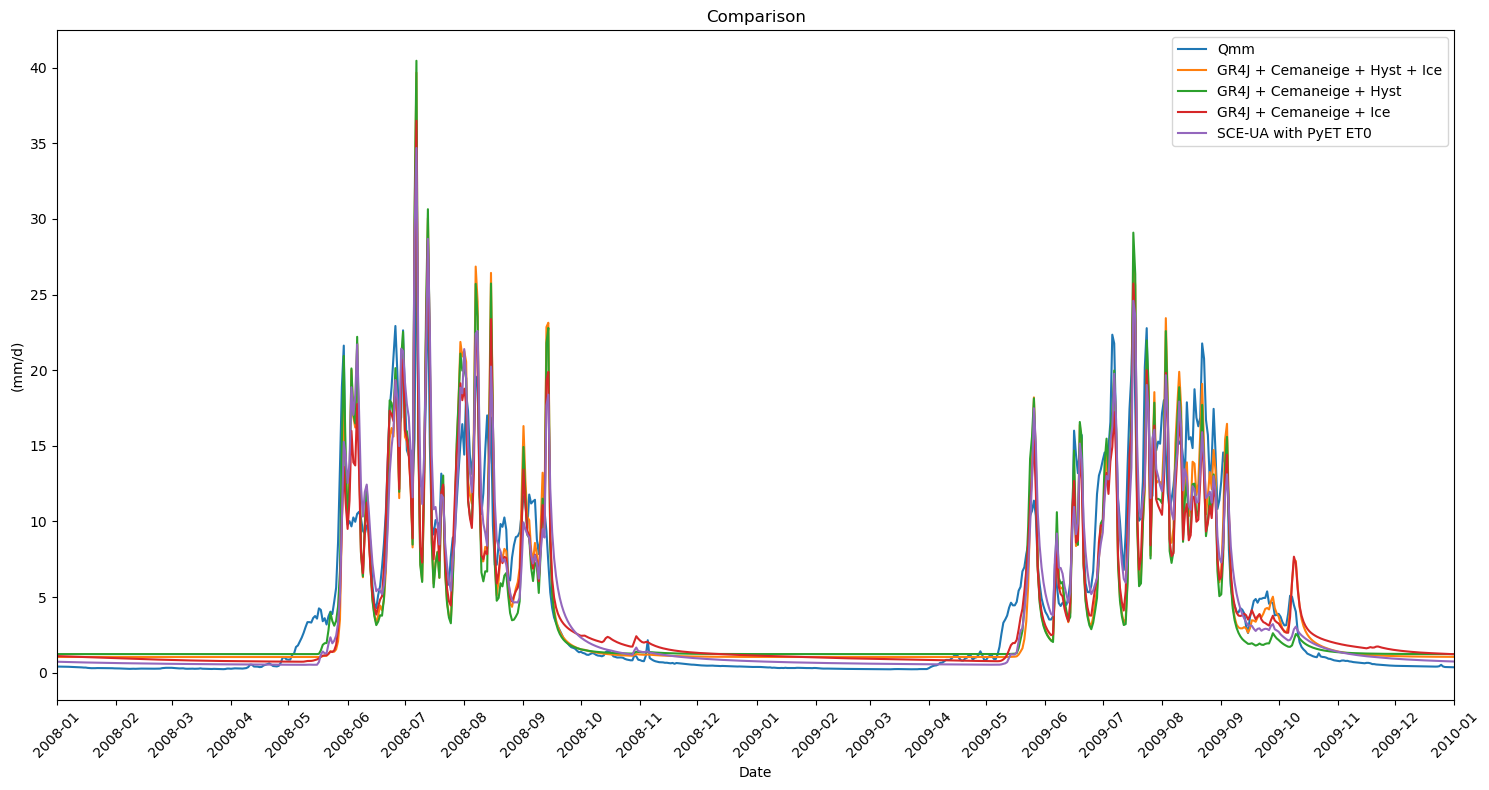

In [32]:
# Define the date range for slicing
s1, e1 = ("2008-01-01", "2010-01-01")

# Create a figure with a larger width
plt.figure(figsize=(15, 8))

# Plot the columns within the specified date range
df1.loc[s1:e1, "Qmm"].plot(label="Qmm")
df1.loc[s1:e1, "sim HystIce(mm/d)"].plot(label="GR4J + Cemaneige + Hyst + Ice")
df1.loc[s1:e1, "sim Hyst(mm/d)"].plot(label="GR4J + Cemaneige + Hyst")
df1.loc[s1:e1, "sim CemaneigeIce(mm/d)"].plot(label="GR4J + Cemaneige + Ice")
df1.loc[s1:e1, "Q_sceua(mm/d)"].plot(label="SCE-UA with PyET ET0")

# Add legend, labels, and title 
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.ylabel("(mm/d)")
plt.title("Comparison")

# Display the plot
plt.tight_layout()
plt.show()


In [34]:
# Calculate the different KGE values
kge_hyst_ice = kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim HystIce(mm/d)"])
kge_hyst = kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim Hyst(mm/d)"])
kge_cemaneigeice = kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "sim CemaneigeIce(mm/d)"])
kge_sceua = kge(df1.loc[s1:e1, "Qmm"], df1.loc[s1:e1, "Q_sceua(mm/d)"])

# Print the results
print("KGE for GR4J + Cemaneige + Hyst + Ice:", kge_hyst_ice)
print("KGE for GR4J + Cemaneige + Hyst:", kge_hyst)
print("KGE for GR4J + Cemaneige + Ice:", kge_cemaneigeice)
print("KGE for SCE-UA with PyET ET0:", kge_sceua)

KGE for GR4J + Cemaneige + Hyst + Ice: 0.9083744811016721
KGE for GR4J + Cemaneige + Hyst: 0.8965609667574627
KGE for GR4J + Cemaneige + Ice: 0.8662690159727797
KGE for SCE-UA with PyET ET0: 0.9198882934471039


In [ ]:
# Save df1 as a csv file
df1.to_csv("df1.csv", sep=";",decimal=".")